<a href="https://colab.research.google.com/github/jonas-jr/BD-BIA/blob/main/JonasJunior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Lista de Exercícios 4 - Computação de Alto Desempenho.

Discente: Jonas Gomes da Silva Junior - 202005489.<br>



In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [2]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git -q

  Preparing metadata (setup.py) ... done


In [3]:
%load_ext nvcc_plugin

directory /content/src already exists
Out bin /content/result.out


# 3

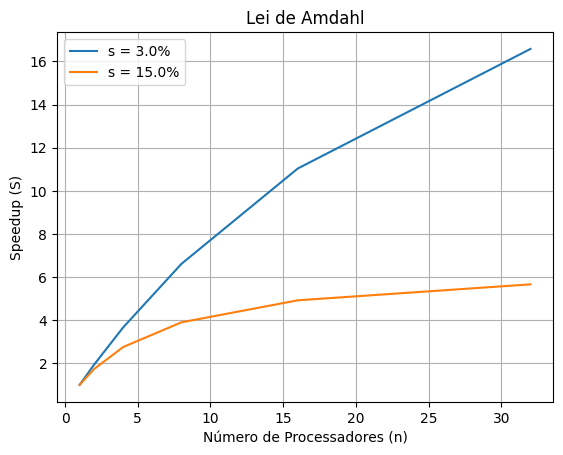

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Definindo o número de processadores
n = np.array([1, 2, 4, 8, 16, 32])

# Definindo a fração estritamente serial (1 - p)
s_values = [0.03, 0.15]

# Criando um gráfico para cada valor de p
for serial in s_values:
    paralel = 1 - serial
    speedup = 1 / (serial + paralel/n)
    plt.plot(n, speedup, label=f"s = {serial*100}%")

# Configurando o gráfico
plt.xlabel('Número de Processadores (n)')
plt.ylabel('Speedup (S)')
plt.title('Lei de Amdahl')
plt.legend()
plt.grid(True)
plt.show()

#4

In [5]:
def amdahl (paralel, n):
    serial = 1 - paralel
    return 1 / (serial + paralel/n)

def gustafson (paralel, n):
    serial = 1 - paralel
    return paralel + serial*n

paralel = 0.06
n = 12
print(f"speedup Amdahl: {amdahl(paralel, n): .4f}")
print(f"speedup Gustafson: {gustafson(paralel, n): .4f}")

speedup Amdahl:  1.0582
speedup Gustafson:  11.3400


#11

In [6]:
%%writefile hello_world.c
#include <stdio.h>
#include <omp.h>

int main() {
  printf("Hello, world!\n");
  #pragma omp parallel num_threads(omp_get_num_procs())
    printf("%d ", omp_get_thread_num());
  printf("\n");
  return 0;
}

Writing hello_world.c


In [7]:
%%writefile fibonacci.c
#include <stdio.h>
#include <omp.h>

long fib (int n) {
  return n < 2 ? 1 : fib(n-1) + fib(n-2);
}

int main() {
  int n = 40;
  #pragma omp parallel num_threads(omp_get_num_procs())
  {
    int t = omp_get_thread_num();
    printf("%d: %ld\n", t, fib(n+t));
  }
  printf("%d ", omp_get_thread_num());
  printf("\n");
  return 0;
}

Writing fibonacci.c


In [8]:
!gcc -o hello_world -fopenmp hello_world.c
!./hello_world

Hello, world!
0 1 


In [9]:
!gcc -o fibonacci -fopenmp fibonacci.c
!./fibonacci

0: 165580141
1: 267914296
0 


#12

In [10]:
%%writefile soma.c
#include <stdio.h>
#include <unistd.h>
#include <omp.h>

int main(int argc, char *argv[]) {
  long int max; sscanf(argv[1], "%ld", &max);
  long int sum = 0;
  #pragma omp parallel for reduction(+:sum) schedule(runtime) num_threads(4)
    for (int i = 1; i <= max; i++) {
      printf("%2d @ %d\n", i, omp_get_thread_num());
      sleep(i<4 ? i+1 : 1);
      sum = sum + i;
    }
  printf("%ld\n", sum);
  return 0;
}

Writing soma.c


In [11]:
!gcc -o soma -fopenmp soma.c
!./soma 20

 2 @ 0
 3 @ 2
 4 @ 1
 1 @ 3
 5 @ 1
 6 @ 1
 7 @ 3
 8 @ 0
 9 @ 1
10 @ 3
11 @ 2
12 @ 0
13 @ 1
14 @ 3
15 @ 2
16 @ 0
17 @ 1
18 @ 3
19 @ 2
20 @ 0
210


#14

In [ ]:
%%writefile soma_sem_reduction.c
#include <stdio.h>
#include <omp.h>

int main(int argc, char *argv[]) {
  long int max; sscanf(argv[1], "%ld", &max);
  int ts = omp_get_max_threads();
  printf("NUMERO DE THREADS: %d\n", ts);
  if (max % ts != 0){
    printf("%ld NAO DIVISIVEL POR %d\n", max, ts);
    return 1;
  }
  int sums[ts];
  #pragma omp parallel
  {
    int t = omp_get_thread_num();
    int lo = (max / ts) * (t + 0) + 1;
    int hi = (max / ts) * (t + 1) + 0;
    sums[t] = 0;
    for (int i = lo; i <= hi; i++)
      sums[t] = sums[t] + i;
  }
  int sum = 0;
  for (int t = 0; t < ts; t++)
    sum = sum + sums[t];
  printf("%d\n", sum);
  return 0;
}

Writing soma_sem_reduction.c


In [ ]:
!gcc -o soma_sem_reduction -fopenmp soma_sem_reduction.c
!./soma_sem_reduction 20

NUMERO DE THREADS: 2
210


In [ ]:
!./soma_sem_reduction 19

NUMERO DE THREADS: 2
19 NAO DIVISIVEL POR 2


###Modificando:

In [ ]:
%%writefile soma_sem_reduction_2.c
#include <stdio.h>
#include <omp.h>

int main(int argc,char *argv[]) {
  long int max; sscanf(argv[1], "%ld", &max);
  int ts = omp_get_max_threads();
  printf("NUMERO DE THREADS: %d\n", ts);
  int sums[ts];
  #pragma omp parallel
  {
    int t = omp_get_thread_num();
    int base = max / ts;
    int leftover = max % ts;
    int lo = base * t + (t < leftover ? t : leftover) + 1;
    int hi = lo + base - (t < leftover ? 0 : 1);
    sums[t] = 0;
    for (int i = lo; i <= hi; i++)
      sums[t] = sums[t] + i;
  }
  int sum = 0;
  for (int t = 0; t < ts; t++)
    sum = sum + sums[t];
  printf("%d\n", sum);
  return 0;
}

Writing soma_sem_reduction_2.c


In [ ]:
!gcc -o soma_sem_reduction_2 -fopenmp soma_sem_reduction_2.c
!./soma_sem_reduction_2 19

NUMERO DE THREADS: 2
190


In [7]:
%%writefile salario.c

#include <stdio.h>
#include <stdlib.h>
#include <omp.h>

int main(int argc, char *argv[])
{
    int n = 500000;
    int sal_base[n], horas[n], vale_alim[n];

    printf("Gerando o salário de 500.000 funcionarios.\n");

    for(int i=0; i < n; i++){
        sal_base[i]=100+(rand()%200);
        horas[i]=10+(rand()%51);
        vale_alim[i]=400+(rand()%600);
    }
    printf("Geracao ok.\n");

    return 0;
}

Writing salario.c


In [9]:
!gcc -o salario -fopenmp salario.c
!./salario.c 8

/bin/bash: line 1: ./salario.c: Permission denied


#2

In [18]:
%%writefile funcionarios.c
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>

#define NUM_FUNCIONARIOS 500000
#define SALARIO_MINIMO 1302

int main(int argc, char *argv[]) {
    int sal_base[NUM_FUNCIONARIOS], horas[NUM_FUNCIONARIOS], vale_alim[NUM_FUNCIONARIOS];
    double salario[NUM_FUNCIONARIOS], salario_total = 0;
    int abaixo_salario_minimo = 0;

    printf("Gerando o salário de 500.000 funcionários.\n");

    for (int i = 0; i < NUM_FUNCIONARIOS; i++) {
        sal_base[i] = 100 + (rand() % 200);
        horas[i] = 10 + (rand() % 51);
        vale_alim[i] = 400 + (rand() % 600);
    }
    printf("Geração ok.\n");

    #pragma omp parallel for reduction(+:salario_total) reduction(+:abaixo_salario_minimo)
    for (int i = 0; i < NUM_FUNCIONARIOS; i++) {
        salario[i] = sal_base[i] * horas[i] + vale_alim[i];

        if (salario[i] < SALARIO_MINIMO) {
            abaixo_salario_minimo++;
        }

        salario_total += salario[i];
    }

    printf("Quantidade de funcionários com salário abaixo do salário mínimo: %d\n", abaixo_salario_minimo);
    printf("Salário total de todos os funcionários: %.2f\n", salario_total);

    // Cálculo do speedup
    int num_threads[] = {1, 2, 4, 8};
    double tempo_inicial, tempo_final, tempo_paralelo;

    for (int i = 0; i < 4; i++) {
        omp_set_num_threads(num_threads[i]);

        tempo_inicial = omp_get_wtime();

        #pragma omp parallel for
        for (int j = 0; j < NUM_FUNCIONARIOS; j++) {
            salario[j] = sal_base[j] * horas[j] + vale_alim[j];
        }

        tempo_final = omp_get_wtime();
        tempo_paralelo = tempo_final - tempo_inicial;

        printf("Speedup com %d threads: %.2f\n", num_threads[i], tempo_paralelo);
    }

    return 0;
}


/*Neste programa, utilizamos a diretiva #pragma omp parallel for para paralelizar o cálculo do salário de cada funcionário. Também utilizamos a cláusula reduction para calcular a soma total dos salários e a quantidade de funcionários com salário abaixo do salário mínimo.

O cálculo do speedup é realizado para 1, 2, 4 e 8 threads, utilizando a função omp_get_wtime() para medir o tempo de execução em cada caso. O speedup é uma medida do ganho de desempenho ao utilizar várias threads para resolver o problema em paralelo, e é calculado pela razão entre o tempo de execução sequencial e o tempo de execução paralelo.

O programa gera os dados aleatórios dos salários e horas trabalhadas para os 500.000 funcionários, calcula os salários, verifica os funcionários com salário abaixo do mínimo, calcula o salário total e imprime os resultados. Em seguida, calcula e imprime o speedup para as diferentes quantidades de threads especificadas. */

Overwriting funcionarios.c


In [19]:
!gcc -o funcionarios funcionarios.c -fopenmp
!./funcionarios


#3

In [32]:
%%writefile static.c
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>
#include <unistd.h>

#define max 14

int main()
{
    long int sum = 0;

    #pragma omp parallel for reduction (+:sum) schedule(static, 1)
    for (int i = 1; i <= max; i++)
    {
        printf("%d @ %d\n", i, omp_get_thread_num());
        sleep((i > 2 && i < 8) ? i + 1 : 1);
        sum = sum + i;
    }

    printf("%ld\n", sum); // Utilize %ld para long int
    return 0;
}

/* Estratégia de Escalonamento static, 1(1 tópico):

Todas as iterações eram executadas por um único thread disponível.
Estratégia de Escalonamento static, 2(2 tópicos):

As iterações seriam divididas igualmente entre as duas threads.
A primeira thread executa as iterações de 1 a 7.
Uma segunda thread executa as iterações de 8 a 14.
Estratégia de Escalonamento static, 3(3 tópicos):

As iterações seriam divididas igualmente entre as três threads.
A primeira thread executa as iterações de 1 a 4.
Uma segunda thread executa as iterações de 5 a 9.
Uma terceira thread executa as iterações de 10 a 14.
*/

Writing static.c


In [33]:
!gcc -o static static.c -fopenmp
!./static


2 @ 1
1 @ 0
4 @ 1
3 @ 0
5 @ 0
6 @ 1
7 @ 0
8 @ 1
10 @ 1
12 @ 1
14 @ 1
9 @ 0
11 @ 0
13 @ 0
105


In [38]:
%%writefile dynamic.c

#include <stdio.h>
#include <stdlib.h>
#include <omp.h>
#include <unistd.h>

#define max 14

int main()
{
    long int sum = 0;

    #pragma omp parallel for reduction (+:sum) schedule(dynamic, 1)
    for (int i = 1; i <= max; i++)
    {
        printf("%d @ %d\n", i, omp_get_thread_num());
        sleep((i > 2 && i < 8) ? i + 1 : 1);
        sum = sum + i;
    }

    printf("%ld\n", sum); // Utilize %ld para long int
    return 0;
}

/* Estratégia de Escalonamento dynamic, 1(1 tópico):

Cada thread executará uma iteração por vez, pois o tamanho do chunk é 1. A primeira thread executará a iteração 1, a segunda executará a iteração 2 e assim por diante.
Estratégia de Escalonamento dynamic, 2(2 tópicos):

O programa elogiou atribuindo um pedaço de tamanho 2 para cada fio.
A primeira thread executará as iterações 1 e 2, enquanto a segunda thread executará as iterações 3 e 4.
À medida que as threads concluem seus chunks, esperando novas iterações, uma de cada vez.
Estratégia de Escalonamento dynamic, 3(3 tópicos):

O programa elogiou atribuindo um pedaço de tamanho 3 para cada fio.
A primeira thread executará as iterações 1, 2 e 3, a segunda thread executará as iterações 4, 5 e 6 e a terceira thread executará as iterações 7, 8 e 9.*/

Overwriting dynamic.c


In [37]:
!gcc -o dynamic dynamic.c -fopenmp
!./dynamic


1 @ 0
2 @ 1
3 @ 0
4 @ 1
5 @ 0
6 @ 1
7 @ 0
8 @ 1
9 @ 1
10 @ 1
11 @ 1
12 @ 1
13 @ 1
14 @ 0
105


speedup:

In [40]:
%%writefile speedup.c
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>
#include <unistd.h>

#define max 14

int main()
{
    long int sum = 0;
    double tempo_inicial, tempo_final;

    // Início da contagem de tempo
    tempo_inicial = omp_get_wtime();

    #pragma omp parallel for reduction (+:sum) schedule(static, 1) #aqui calcula o tempo static1
    for (int i = 1; i <= max; i++)
    {
        printf("%d @ %d\n", i, omp_get_thread_num());
        sleep((i > 2 && i < 8) ? i + 1 : 1);
        sum = sum + i;
    }

    // Fim da contagem de tempo
    tempo_final = omp_get_wtime();

    printf("Tempo de execução: %lf segundos\n", tempo_final - tempo_inicial);
    printf("%ld\n", sum); // Utilize %ld para long int
    return 0;
}


Writing speedup.c


In [41]:
!gcc -o speedup speedup.c -fopenmp
!./speedup


2 @ 1
1 @ 0
4 @ 1
3 @ 0
5 @ 0
6 @ 1
7 @ 0
8 @ 1
10 @ 1
12 @ 1
14 @ 1
9 @ 0
11 @ 0
13 @ 0
Tempo de execução: 22.004888 segundos
105


Speedup = Tempo de Execução Sequencial / Tempo de Execução Paralelo


In [44]:
/* Sequencial para medir speedup*/
#include <stdio.h>
#include <stdlib.h>
#include <unistd.h>

#define max 14

int main()
{
    long int sum = 0;
    double tempo_inicial, tempo_final;

    // Início da contagem de tempo
    tempo_inicial = omp_get_wtime();

    for (int i = 1; i <= max; i++)
    {
        printf("%d\n", i);
        sleep((i > 2 && i < 8) ? i + 1 : 1);
        sum = sum + i;
    }

    // Fim da contagem de tempo
    tempo_final = omp_get_wtime();

    printf("Tempo de execução sequencial: %lf segundos\n", tempo_final - tempo_inicial);
    printf("%ld\n", sum); // Utilize %ld para long int
    return 0;
}


SyntaxError: ignored

In [46]:
/* Uma condição de corrida (ou "condição de corrida") ocorre quando o resultado de um programa paralelo varia dependendo da ordem em que os threads executam suas tarefas. Em outras palavras, é uma situação em que múltiplos threads acessam e modificam uma variável compartilhada de forma concorrente, e o resultado final depende da sincronização entre esses threads.

No código apresentado, não há uma condição de corrida, pois a variável sumé utilizada com a cláusula reduction, que garante que a operação de soma seja realizada de forma segura e sem problemas de concorrência. A cláusula reductioncria uma cópia privada da variável sumpara cada thread e, ao final da execução do loop, realiza a operação de redução (nesse caso, a soma) de todas as cópias privadas para obter o resultado final.

Essa abordagem evita conflitos de escrita simultânea na variável sume garante que o resultado da soma seja correto, independentemente da ordem em que as threads executam suas iterações do loop. Portanto, não há condição de corrida nesse código devido ao uso apropriado da cláusula reduction. */

SyntaxError: ignored